<a href="https://colab.research.google.com/github/respect5716/deep-learning-paper-implementation/blob/main/02_Vision/InterFaceGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# InterFaceGAN

## 0. Info

### Paper
* title: InterFaceGAN: Interpreting the Disentangled Face Representation Learned by GANs
* author: Yujun Shen et al.
* url: https://arxiv.org/abs/2005.09635

### Features
* Attribute: Pose

### Reference
* https://github.com/genforce/interfacegan
* https://github.com/thohemp/6DRepNet

## 1. Setup

In [ ]:
# prepare
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
!cp -r stylegan2-ada-pytorch/torch_utils .
!cp -r stylegan2-ada-pytorch/dnnlib .

!wget https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl # FFHQ StyleGAN2
!gdown 1vPNtVu_jg2oK-RiIWakxYyfLPA9rU4R4 # pretrained head pose estimator 6DRepNet

In [ ]:
!pip install -q ninja

In [15]:
import os
import pickle
import easydict
from glob import glob
from tqdm.auto import tqdm
from PIL import Image

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as pl
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

In [2]:
cfg = easydict.EasyDict(
    num_samples = 30000,
    latent_type = 'w',

    device = 'cuda',
    dataset_dir = '/content/drive/Shareddrives/dataset',
)

## 2. Attribute Model

In [3]:
# modules
class SEBlock(nn.Module):
    def __init__(self, input_channels, internal_neurons):
        super(SEBlock, self).__init__()
        self.down = nn.Conv2d(in_channels=input_channels, out_channels=internal_neurons, kernel_size=1, stride=1, bias=True)
        self.up = nn.Conv2d(in_channels=internal_neurons, out_channels=input_channels, kernel_size=1, stride=1, bias=True)
        self.input_channels = input_channels

    def forward(self, inputs):
        x = F.avg_pool2d(inputs, kernel_size=inputs.size(3))
        x = self.down(x)
        x = F.relu(x)
        x = self.up(x)
        x = torch.sigmoid(x)
        x = x.view(-1, self.input_channels, 1, 1)
        return inputs * x
    

def conv_bn(in_channels, out_channels, kernel_size, stride, padding, groups=1):
    result = nn.Sequential()
    result.add_module('conv', nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=groups, bias=False))
    result.add_module('bn', nn.BatchNorm2d(num_features=out_channels))
    return result


class RepVGGBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, dilation=1, groups=1, padding_mode='zeros', deploy=False, use_se=False):
        super(RepVGGBlock, self).__init__()
        assert kernel_size == 3
        assert padding == 1

        self.deploy = deploy
        self.groups = groups
        self.in_channels = in_channels
        padding_11 = padding - kernel_size // 2
        self.nonlinearity = nn.ReLU()

        if use_se:
            self.se = SEBlock(out_channels, internal_neurons=out_channels // 16)
        else:
            self.se = nn.Identity()

        if deploy:
            self.rbr_reparam = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride,
                                      padding=padding, dilation=dilation, groups=groups, bias=True, padding_mode=padding_mode)
        else:
            self.rbr_identity = nn.BatchNorm2d(num_features=in_channels) if out_channels == in_channels and stride == 1 else None
            self.rbr_dense = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=groups)
            self.rbr_1x1 = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, padding=padding_11, groups=groups)
            print('RepVGG Block, identity = ', self.rbr_identity)

    def forward(self, inputs):
        if hasattr(self, 'rbr_reparam'):
            return self.nonlinearity(self.se(self.rbr_reparam(inputs)))
        if self.rbr_identity is None:
            id_out = 0
        else:
            id_out = self.rbr_identity(inputs)
        return self.nonlinearity(self.se(self.rbr_dense(inputs) + self.rbr_1x1(inputs) + id_out))


class RepVGG(nn.Module):
    def __init__(self, num_blocks, num_classes=1000, width_multiplier=None, override_groups_map=None, deploy=False, use_se=False):
        super(RepVGG, self).__init__()
        assert len(width_multiplier) == 4

        self.deploy = deploy
        self.override_groups_map = override_groups_map or dict()
        self.use_se = use_se
        assert 0 not in self.override_groups_map
        self.in_planes = min(64, int(64 * width_multiplier[0]))

        self.stage0 = RepVGGBlock(in_channels=3, out_channels=self.in_planes, kernel_size=3, stride=2, padding=1, deploy=self.deploy, use_se=self.use_se)
        self.cur_layer_idx = 1
        self.stage1 = self._make_stage(int(64 * width_multiplier[0]), num_blocks[0], stride=2)
        self.stage2 = self._make_stage(int(128 * width_multiplier[1]), num_blocks[1], stride=2)
        self.stage3 = self._make_stage(int(256 * width_multiplier[2]), num_blocks[2], stride=2)
        self.stage4 = self._make_stage(int(512 * width_multiplier[3]), num_blocks[3], stride=2)
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.linear = nn.Linear(int(512 * width_multiplier[3]), num_classes)

    def _make_stage(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        blocks = []
        for stride in strides:
            cur_groups = self.override_groups_map.get(self.cur_layer_idx, 1)
            blocks.append(RepVGGBlock(in_channels=self.in_planes, out_channels=planes, kernel_size=3,
                                      stride=stride, padding=1, groups=cur_groups, deploy=self.deploy, use_se=self.use_se))
            self.in_planes = planes
            self.cur_layer_idx += 1
        return nn.Sequential(*blocks)

    def forward(self, x):
        out = self.stage0(x)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)
        out = self.gap(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
    
def create_RepVGG_B1g2(deploy=False):
    optional_groupwise_layers = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26]
    g2_map = {l: 2 for l in optional_groupwise_layers}
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000, width_multiplier=[2, 2, 2, 4], override_groups_map=g2_map, deploy=deploy)

In [4]:
# utils
def normalize_vector(v, use_gpu=True):
    batch = v.shape[0]
    v_mag = torch.sqrt(v.pow(2).sum(1))# batch
    if use_gpu:
        v_mag = torch.max(v_mag, torch.autograd.Variable(torch.FloatTensor([1e-8]).cuda()))
    else:
        v_mag = torch.max(v_mag, torch.autograd.Variable(torch.FloatTensor([1e-8])))  
    v_mag = v_mag.view(batch,1).expand(batch,v.shape[1])
    v = v/v_mag
    return v

def cross_product( u, v):
    batch = u.shape[0]
    #print (u.shape)
    #print (v.shape)
    i = u[:,1]*v[:,2] - u[:,2]*v[:,1]
    j = u[:,2]*v[:,0] - u[:,0]*v[:,2]
    k = u[:,0]*v[:,1] - u[:,1]*v[:,0]
    out = torch.cat((i.view(batch,1), j.view(batch,1), k.view(batch,1)),1)#batch*3
    return out

def compute_rotation_matrix_from_ortho6d(poses, use_gpu=True):
    x_raw = poses[:,0:3]#batch*3
    y_raw = poses[:,3:6]#batch*3
        
    x = normalize_vector(x_raw, use_gpu) #batch*3
    z = cross_product(x, y_raw) #batch*3
    z = normalize_vector(z, use_gpu)#batch*3
    y = cross_product(z, x)#batch*3
        
    x = x.view(-1,3,1)
    y = y.view(-1,3,1)
    z = z.view(-1,3,1)
    matrix = torch.cat((x,y,z), 2) #batch*3*3
    return matrix

def compute_euler_angles_from_rotation_matrices(rotation_matrices, use_gpu=True):
    batch = rotation_matrices.shape[0]
    R = rotation_matrices
    sy = torch.sqrt(R[:,0,0]*R[:,0,0]+R[:,1,0]*R[:,1,0])
    singular = sy<1e-6
    singular = singular.float()

    x = torch.atan2(R[:,2,1], R[:,2,2])
    y = torch.atan2(-R[:,2,0], sy)
    z = torch.atan2(R[:,1,0],R[:,0,0])

    xs = torch.atan2(-R[:,1,2], R[:,1,1])
    ys = torch.atan2(-R[:,2,0], sy)
    zs = R[:,1,0]*0

    if use_gpu:
        out_euler = torch.autograd.Variable(torch.zeros(batch,3).cuda())
    else:
        out_euler = torch.autograd.Variable(torch.zeros(batch,3))  
    out_euler[:,0] = x*(1-singular)+xs*singular
    out_euler[:,1] = y*(1-singular)+ys*singular
    out_euler[:,2] = z*(1-singular)+zs*singular
    return out_euler # (pitch, yaw, roll)

In [5]:
# 6DRepNet
class SixDRepNet(nn.Module):
    def __init__(self, backbone_file, deploy, bins = (1, 2, 3, 6), pretrained = True):
        super(SixDRepNet, self).__init__()
        backbone = create_RepVGG_B1g2(deploy)
        if pretrained:
            checkpoint = torch.load(backbone_file)
            if 'state_dict' in checkpoint:
                checkpoint = checkpoint['state_dict']
            ckpt = {k.replace('module.', ''): v for k,
                    v in checkpoint.items()}  # strip the names
            backbone.load_state_dict(ckpt)

        self.layer0, self.layer1, self.layer2, self.layer3, self.layer4 = backbone.stage0, backbone.stage1, backbone.stage2, backbone.stage3, backbone.stage4
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        last_channel = 0
        for n, m in self.layer4.named_modules():
            if ('rbr_dense' in n or 'rbr_reparam' in n) and isinstance(m, nn.Conv2d):
                last_channel = m.out_channels

        fea_dim = last_channel
        self.linear_reg = nn.Linear(fea_dim, 6)

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.linear_reg(x)
        return compute_rotation_matrix_from_ortho6d(x)

## 3. Generate samples

In [6]:
def image_to_tensor(img, img_size=None):
    size = (img_size, img_size) if img_size else (img.height, img.width)
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    return transform(img)

def tensor_to_image(tensor):
    image = (tensor.permute(1, 2, 0) * 127.5 + 128).clamp(0, 255).to(torch.uint8).detach().cpu().numpy()
    return Image.fromarray(image)


def sample_latent(G, latent_type='z', num_samples=10000):
    if latent_type == 'z':
        return torch.randn(num_samples, G.z_dim)
    
    elif latent_type == 'w':
        return torch.randn(num_samples, G.w_dim)
    
    elif latent_type == 'wp':
        return torch.randn(num_samples, G.num_ws, G.w_dim)

In [7]:
pose_model = SixDRepNet(backbone_file='', deploy=True, pretrained=False)
pose_model.load_state_dict(torch.load('6DRepNet_300W_LP_AFLW2000.pth'))
_ = pose_model.requires_grad_(False).eval().to(cfg.device)

pose_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [10]:
G = pickle.load(open('ffhq.pkl', 'rb'))['G_ema'].requires_grad_(False).float().eval().to(cfg.device)

In [11]:
zs = sample_latent(G, num_samples=cfg.num_samples)
latents = np.zeros((zs.size(0), G.w_dim))
poses = np.zeros((zs.size(0), 3))

In [12]:
batch_size = 16
for i in tqdm(range(0, zs.size(0), batch_size)):
    batch = zs[i:i+batch_size].to(cfg.device)
    batch_ws = G.mapping(batch, None)
    batch_gens = G.synthesis(batch_ws, noise_mode='const')        
    batch_imgs = [tensor_to_image(g) for g in batch_gens]
    
    pose_inputs = torch.stack([pose_transform(img) for img in batch_imgs], dim=0).to(cfg.device)
    rmat = pose_model(pose_inputs)
    batch_pos = compute_euler_angles_from_rotation_matrices(rmat) * 180 / np.pi

    if cfg.latent_type == 'z':
        latents[i:i+batch_size] = batch.cpu().numpy()
    else:
        latents[i:i+batch_size] = batch_ws[:, 0, :].cpu().numpy()
    poses[i:i+batch_size] = batch_pos.cpu().numpy()
    
np.save('latents.npy', latents)
np.save('poses.npy', poses)

  0%|          | 0/1875 [00:00<?, ?it/s]

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


## 4. Train Boundary

In [13]:
latents = np.load('latents.npy')
poses = np.load('poses.npy') # (pitch, yaw, roll)

In [17]:
targets = poses[:, 0]
labels = (targets > 0).astype(int)

threshold = 1.
cond = np.abs(targets) >= threshold
X = latents[cond]
y = labels[cond]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=10000, shuffle=True)
X_train.shape, X_test.shape

((10000, 512), (17523, 512))

In [18]:
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

SVC(kernel='linear')

In [19]:
pred_test = clf.predict(X_test)
test_acc = (pred_test == y_test).mean()
print('test accuracy: ', test_acc)

test accuracy:  0.9190207156308852


In [20]:
boundary = clf.coef_ / np.linalg.norm(clf.coef_)
np.save('boundary.npy', boundary)

## 5. Test

In [21]:
def get_image_from_ws(G, ws, size=None):
    with torch.no_grad():
        out = G.synthesis(ws, noise_mode='const')[0]
    out = tensor_to_image(out)
    if size:
        out = T.Resize(size)(out)
    return out

In [ ]:
G = pickle.load(open('ffhq.pkl', 'rb'))['G_ema'].requires_grad_(False).float().eval().to(cfg.device)

In [22]:
bd = np.load('boundary.npy')
bd = torch.tensor(bd).to(cfg.device).unsqueeze(1).repeat(1, G.num_ws, 1)

In [27]:
z = torch.randn(1, G.z_dim).to(cfg.device)
with torch.no_grad():
    ws = G.mapping(z, None)

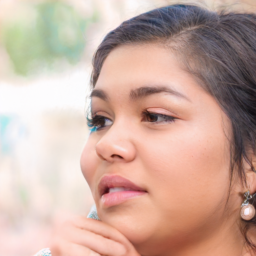

In [28]:
get_image_from_ws(G, ws, 256)

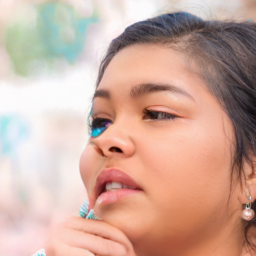

In [30]:
factor = 2
ws2 = ws + factor*bd
get_image_from_ws(G, ws2, 256)